# Anti-Money Laundering
The purpose of this exercise is to analyze financial transactions and test detection models for finding illicit transactions and their associated networks. Anti-Money Laundering (AML) data is difficult to come by due to sensitivities around real transactions. Researchers at IBM created a synthetic dataset which models real world financial transactions and AML networks. The model used to generate the data simulates the real world and includes typical laundering techniques such as placement (the source of the funds), layering (mixing funds around to obfuscate them), and integration (spending the illicit funds) (Suzumura & Kanezashi, 2021).

The goals of this project are to 1) find and visualize the 8 types of illicit laundering patterns, 2) generate graph statistics for use in Gradient Boosted Trees (Altman et al., 2024; Blanuša et al., 2024), and 3) test a Graph Neural Network model on the dataset to compare performance with the GBT's.

#### Table of Contents
1. Admin & Data loading
2. Exploratory Data Analysis
3. Feature Engineering
4. Gradient Boosted Trees
  *   XGBoost
  *   LightGBM
5. Graph Neural Networks
6. Other Models
7. Results


#### Dataset
[IBM Transactions for Anti-Money Laundering](https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml/data)

### References
Altman, E., Blanuša, J., Niederhäusern, L. von, Egressy, B., Anghel, A., & Atasu, K. (2024). Realistic Synthetic Financial Transactions for Anti-Money Laundering Models. https://arxiv.org/abs/2306.16424

Blanuša, J., Cravero Baraja, M., Anghel, A., von Niederhäusern, L., Altman, E., Pozidis, H., & Atasu, K. (2024). Graph Feature Preprocessor: Real-time Subgraph-based Feature Extraction for Financial Crime Detection. Proceedings of the 5th ACM International Conference on AI in Finance, 222–230. https://doi.org/10.1145/3677052.3698674

Suzumura, T., & Kanezashi, H. (2021). Anti-Money Laundering Datasets: InPlusLab Anti-Money Laundering DataDatasets. http://github.com/IBM/AMLSim/


## Admin

In [1]:
install.packages(c('tidymodels', 'tsibble', 'ggpubr', 'tidygraph', 'ggraph', 'lubridate'))

library(readr)
library(tidyverse)
library(tidymodels)
library(tsibble)
library(ggplot2)
library(scales)
library(ggpubr)
library(tidygraph)
library(ggraph)
library(lubridate)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ purrr     1.0.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.3.0 ──

✔ broom        1.0.7     ✔ rsample      1.2.1
✔ dials        1.4.0     ✔ tune         1.3.0
✔ infer        1.0.7     ✔ workflows    1.2.0
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.3.1     ✔ yardstick    1.3.2
✔ recipes      1.2.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts(

In [2]:
# Set default width/height and add function to set individual width/height in ggplot
options(repr.plot.width = 10, repr.plot.height = 6)

fig <- function(width, height){
  options(repr.plot.width = width, repr.plot.height = height)
}

In [3]:
# Data is hosted on Google Drive for easy access here
download.file(
  url = "https://drive.usercontent.google.com/download?id=1g--A98uTakzJFGqkiyPaHiCIJO171JLg&export=download&confirm=t&uuid=321dbe3c-2337-4389-89b2-942221e2ccff",
  destfile = "HI-Small_Trans.zip",
  method = "auto",
  mode = "wb"
)
unzip(zipfile = "HI-Small_Trans.zip", exdir = "./")

In [4]:
# Read CSV and convert to tibble for tidyverse compatibility
transactions_df <- readr::read_csv('HI-Small_Trans.csv') |>
  as_tibble()

New names:
• `Account` -> `Account...3`
• `Account` -> `Account...5`
Rows: 5078345 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): Timestamp, From Bank, Account...3, To Bank, Account...5, Receiving ...
dbl (3): Amount Received, Amount Paid, Is Laundering

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Exploratory Data Analysis

In [ ]:
# Quick glance at the columns, types, length, and data
transactions_df |> str()

tibble [5,078,345 × 11] (S3: tbl_df/tbl/data.frame)
 $ Timestamp         : chr [1:5078345] "2022/09/01 00:20" "2022/09/01 00:20" "2022/09/01 00:00" "2022/09/01 00:02" ...
 $ From Bank         : chr [1:5078345] "010" "03208" "03209" "012" ...
 $ Account...3       : chr [1:5078345] "8000EBD30" "8000F4580" "8000F4670" "8000F5030" ...
 $ To Bank           : chr [1:5078345] "010" "001" "03209" "012" ...
 $ Account...5       : chr [1:5078345] "8000EBD30" "8000F5340" "8000F4670" "8000F5030" ...
 $ Amount Received   : num [1:5078345] 3697.34 0.01 14675.57 2806.97 36682.97 ...
 $ Receiving Currency: chr [1:5078345] "US Dollar" "US Dollar" "US Dollar" "US Dollar" ...
 $ Amount Paid       : num [1:5078345] 3697.34 0.01 14675.57 2806.97 36682.97 ...
 $ Payment Currency  : chr [1:5078345] "US Dollar" "US Dollar" "US Dollar" "US Dollar" ...
 $ Payment Format    : chr [1:5078345] "Reinvestment" "Cheque" "Reinvestment" "Reinvestment" ...
 $ Is Laundering     : num [1:5078345] 0 0 0 0 0 0 0 0 0 0 ...


In [5]:
# Rename columns to a standard format
transactions_df <- transactions_df |>
  rename(
    timestamp = Timestamp,
    from_bank = "From Bank",
    from_account = "Account...3",
    to_bank = "To Bank",
    to_account = "Account...5",
    amount_received = "Amount Received",
    receiving_currency = "Receiving Currency",
    amount_paid = "Amount Paid",
    payment_currency = "Payment Currency",
    payment_format = "Payment Format",
    is_laundering = "Is Laundering"
  )

# Factorize categorical columns & type the timestamp column
transactions_df <- transactions_df |>
  mutate(
    timestamp = ymd_hm(timestamp),
    from_bank = as.factor(transactions_df$from_bank),
    from_account = as.factor(transactions_df$from_account),
    to_bank = as.factor(transactions_df$to_bank),
    to_account = as.factor(transactions_df$to_account),
    receiving_currency = as.factor(transactions_df$receiving_currency),
    payment_currency = as.factor(transactions_df$payment_currency),
    payment_format = as.factor(transactions_df$payment_format),
    is_laundering = as.factor(transactions_df$is_laundering)
  ) |>
  arrange(timestamp)

transactions_df

timestamp,from_bank,from_account,to_bank,to_account,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
<dttm>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>
2022-09-01,03209,8000F4670,03209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
2022-09-01,01420,8005DFEB0,01420,8005DFEB0,897.37,US Dollar,897.37,US Dollar,Reinvestment,0
2022-09-01,010,8000F6850,010,8000F6850,99986.94,US Dollar,99986.94,US Dollar,Reinvestment,0
2022-09-01,012,8001167D0,012,8001167D0,16.08,US Dollar,16.08,US Dollar,Reinvestment,0
2022-09-01,001,8001364A0,001,8001364A0,10.30,US Dollar,10.30,US Dollar,Reinvestment,0
2022-09-01,001,800139380,001,800139380,18.51,US Dollar,18.51,US Dollar,Reinvestment,0
2022-09-01,00220,800132390,00220,800132390,19.23,US Dollar,19.23,US Dollar,Reinvestment,0
2022-09-01,001,8001495E0,001,8001495E0,19227.79,US Dollar,19227.79,US Dollar,Reinvestment,0
2022-09-01,03292,8001541B0,03292,8001541B0,3776.79,US Dollar,3776.79,US Dollar,Reinvestment,0


In [ ]:
# Count null values in each column. If there are nulls, further processing may be required
colSums(is.na(transactions_df))

timestamp          from_bank       from_account            to_bank 
                 0                  0                  0                  0 
        to_account    amount_received receiving_currency        amount_paid 
                 0                  0                  0                  0 
  payment_currency     payment_format      is_laundering 
                 0                  0                  0

### Visualize different aspects of the data relating to laundering vs. not laundering

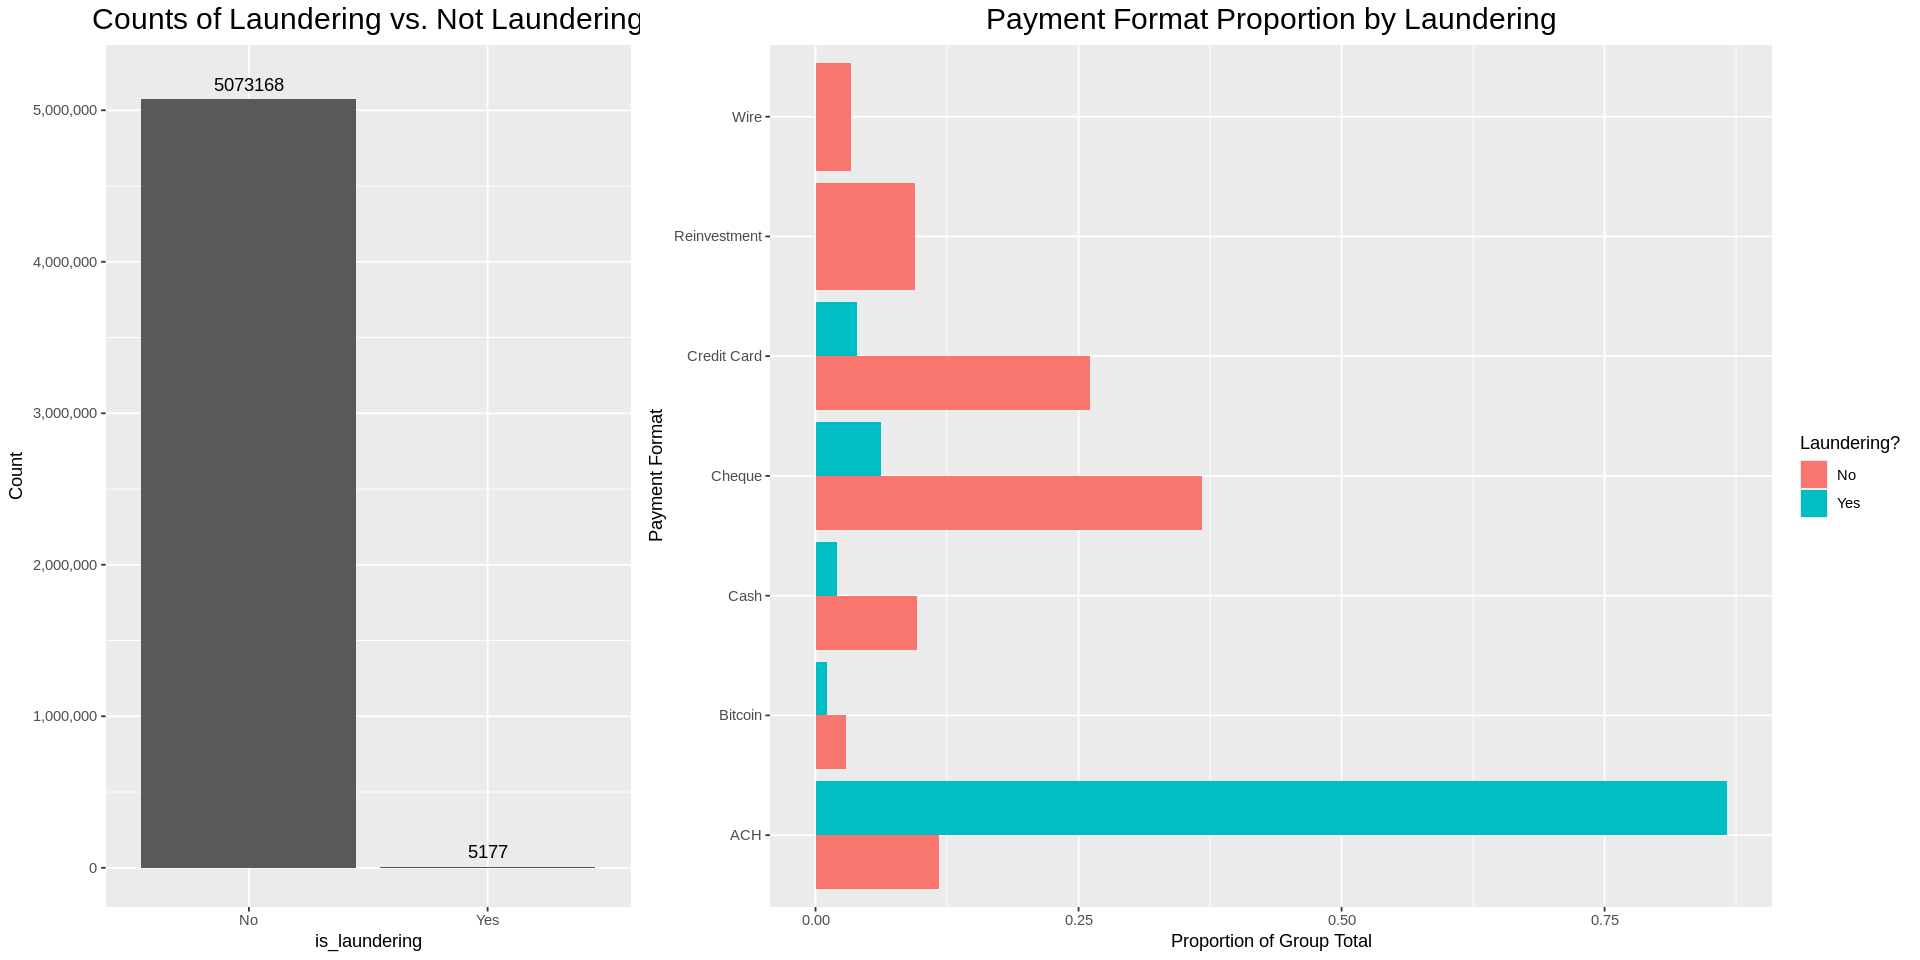

In [ ]:
fig(16,8)
laundering_counts_chart <- transactions_df |>
  count(is_laundering) |>
  ggplot(mapping = aes(x = is_laundering, y = n)) +
    geom_col() +
    geom_text(aes(label = n), nudge_y = 100000) +
    scale_y_continuous(labels = label_comma()) +
    scale_x_discrete(labels = c('No', 'Yes')) +
    labs(title = 'Counts of Laundering vs. Not Laundering', y = 'Count') +
    theme(plot.title = element_text(hjust = 0.5, size = 18))

payment_format_counts_chart <- transactions_df |>
  group_by(is_laundering) |>
  count(payment_format) |>
  mutate(n = n/sum(n)) |>
  ggplot(mapping = aes(x = n, y = payment_format, fill = is_laundering)) +
    geom_col(position = "dodge") +
    labs(title = 'Payment Format Proportion by Laundering', y = 'Payment Format', x = 'Proportion of Group Total', fill = 'Laundering?') +
    scale_fill_discrete(labels = c('No', 'Yes')) +
    theme(plot.title = element_text(hjust = 0.5, size = 18))

ggarrange(laundering_counts_chart, payment_format_counts_chart, ncol = 2, widths = c(1,2))

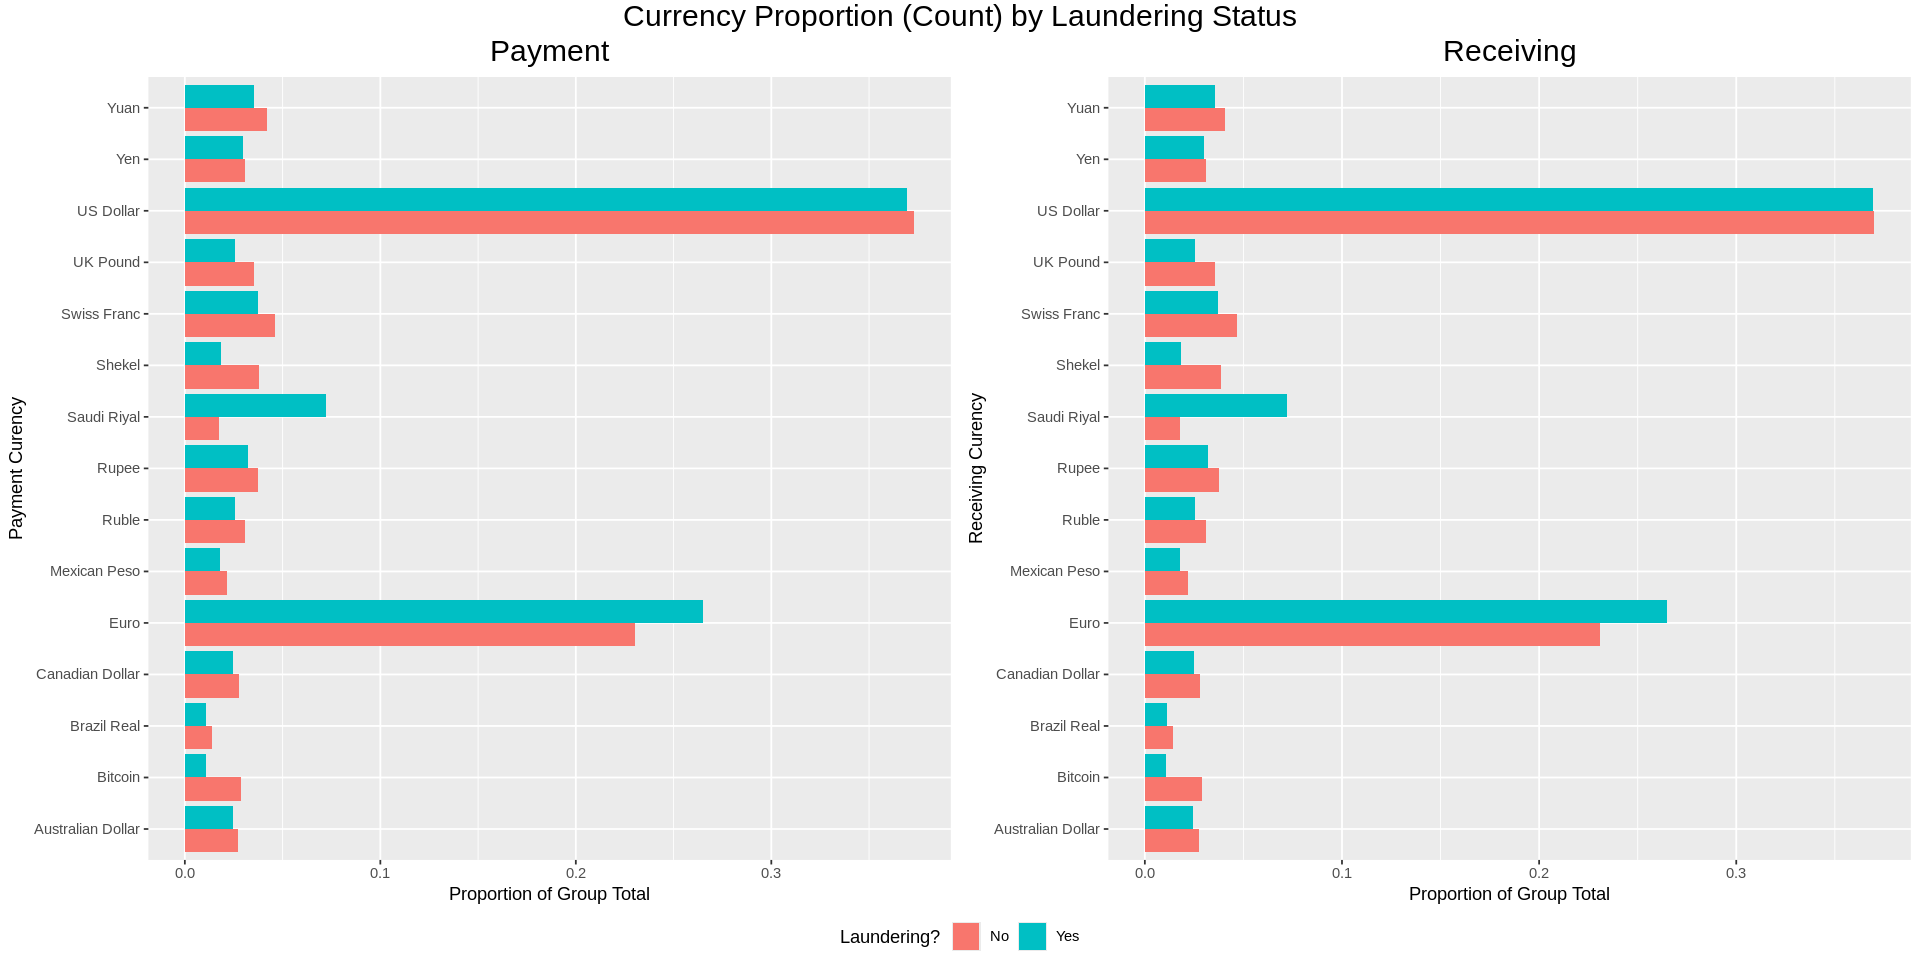

In [ ]:
fig(16,8)
payment_currency_chart <- transactions_df |>
  group_by(is_laundering) |>
  count(payment_currency) |>
  mutate(n = n/sum(n)) |>
  ggplot(mapping = aes(x = n, y = payment_currency, fill = is_laundering)) +
    geom_col(position = "dodge") +
    labs(title = 'Payment', y = 'Payment Curency', x = 'Proportion of Group Total', fill = 'Laundering?') +
    scale_fill_discrete(labels = c('No', 'Yes')) +
    theme(plot.title = element_text(hjust = 0.5, size = 18))

receiving_currency_chart <- transactions_df |>
  group_by(is_laundering) |>
  count(receiving_currency) |>
  mutate(n = n/sum(n)) |>
  ggplot(mapping = aes(x = n, y = receiving_currency, fill = is_laundering)) +
    geom_col(position = "dodge") +
    labs(title = 'Receiving', y = 'Receiving Curency', x = 'Proportion of Group Total', fill = 'Laundering?') +
    scale_fill_discrete(labels = c('No', 'Yes')) +
    theme(plot.title = element_text(hjust = 0.5, size = 18))

plot <- ggarrange(payment_currency_chart, receiving_currency_chart, ncol = 2, common.legend = TRUE, legend = 'bottom')

annotate_figure(plot, top = text_grob('Currency Proportion (Count) by Laundering Status', size = 18))

`summarise()` has grouped output by 'is_laundering'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'is_laundering'. You can override using the
`.groups` argument.


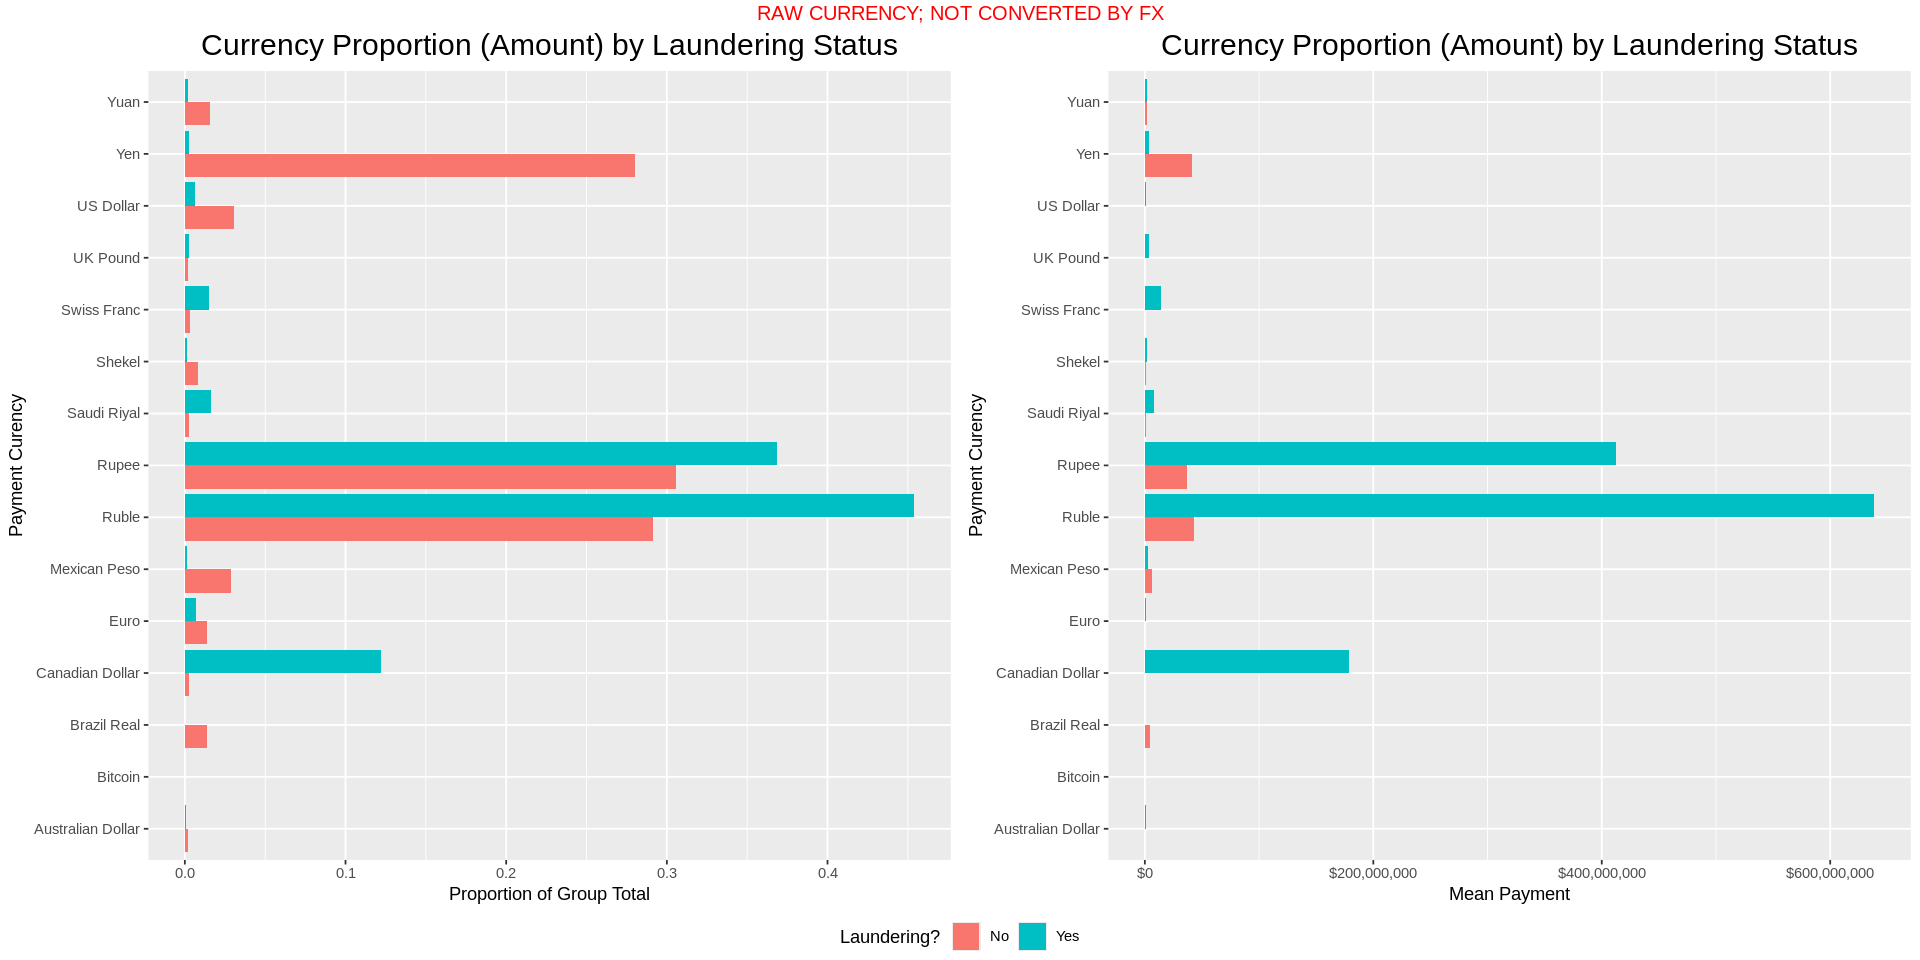

In [ ]:
fig(16,8)
payment_currency_amt_chart <- transactions_df |>
  group_by(is_laundering, payment_currency) |>
  summarise(sum_p = sum(amount_paid)) |>
  mutate(sum_p = sum_p/sum(sum_p)) |>
  ungroup() |>
  ggplot(mapping = aes(x = sum_p, y = payment_currency, fill = is_laundering)) +
    geom_col(position = "dodge") +
    labs(title = 'Currency Proportion (Amount) by Laundering Status', y = 'Payment Curency', x = 'Proportion of Group Total', fill = 'Laundering?') +
    scale_fill_discrete(labels = c('No', 'Yes')) +
    theme(plot.title = element_text(hjust = 0.5, size = 18))

payment_currency_mean_chart <- transactions_df |>
  group_by(is_laundering, payment_currency) |>
  summarise(mean_p = mean(amount_paid)) |>
  ungroup() |>
  ggplot(mapping = aes(x = mean_p, y = payment_currency, fill = is_laundering)) +
    geom_col(position = "dodge") +
    labs(title = 'Currency Proportion (Amount) by Laundering Status', y = 'Payment Curency', x = 'Mean Payment', fill = 'Laundering?') +
    scale_fill_discrete(labels = c('No', 'Yes')) +
    theme(plot.title = element_text(hjust = 0.5, size = 18)) +
    scale_x_continuous(labels = label_currency())

plot <- ggarrange(payment_currency_amt_chart, payment_currency_mean_chart, common.legend = TRUE, legend = 'bottom')
annotate_figure(plot, top = text_grob('RAW CURRENCY; NOT CONVERTED BY FX', size = 12, color = 'red'))

Notes:


*   Most of the laundering transactions are conducted via ACH.
*   USD & Euro account for large proportions of laundering (and legit) transactions.



### Visualize Network Map
Get a sense of the network and see if we can track down the 8 laundering patterns contained in the data.

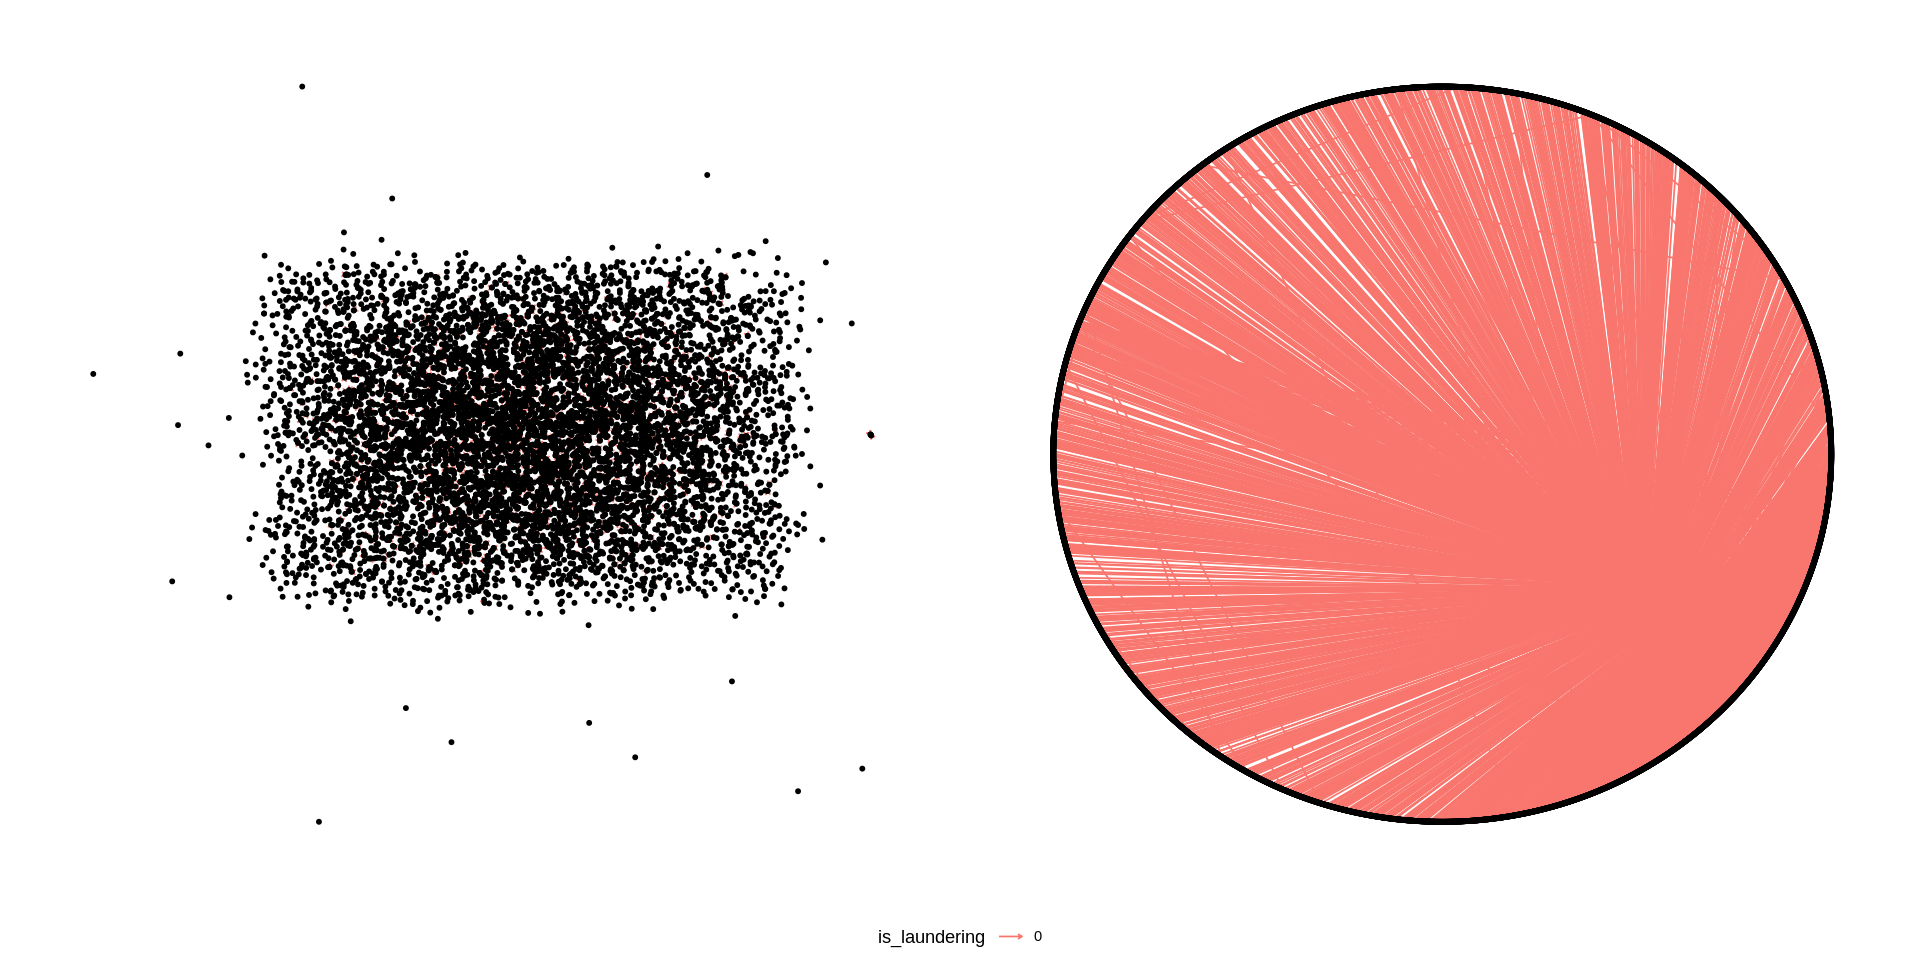

In [ ]:
fig(16,8)
# First, get a general picture of the graph. Using a sample so the graph isn't overcrowded
general_graph_chart <- transactions_df |>
  filter(payment_format != "Wire" | payment_format != "Reinvestment") |>
  slice_head(n = 7500) |>
  select(from_account, to_account, is_laundering) |>
  rename(from = from_account, to = to_account) |>
  as_tbl_graph(directed = TRUE) |>
  activate(edges)

general_graph_chart_fr <- ggraph(general_graph_chart, layout = "fr") +
  geom_edge_link(aes(color = is_laundering), arrow = arrow(length = unit(1, 'mm'))) +
  geom_node_point(size = 1) +
  theme_graph(base_family = "sans")

general_graph_chart_kk <- ggraph(general_graph_chart, layout = "circle") +
  geom_edge_link(aes(color = is_laundering), arrow = arrow(length = unit(1, 'mm'))) +
  geom_node_point(size = 1) +
  theme_graph(base_family = "sans")

ggarrange(general_graph_chart_fr, general_graph_chart_kk, common.legend = TRUE, legend = 'bottom')

In [ ]:
# Calculate self-loops vs connected
general_graph_chart |>
  as_tibble() |>
  summarise(
    self_loops = sum(from == to),
    connected = sum(from != to)
  ) |> print()

# A tibble: 1 × 2
  self_loops connected
       <int>     <int>
1       5480      2020


By looking at the chart and statistics we can see that most transactions in the sample are 1-1 or 1-self. Few nodes connect to multiple other nodes. Let's see if we can find some of the patterns described in the research papers.

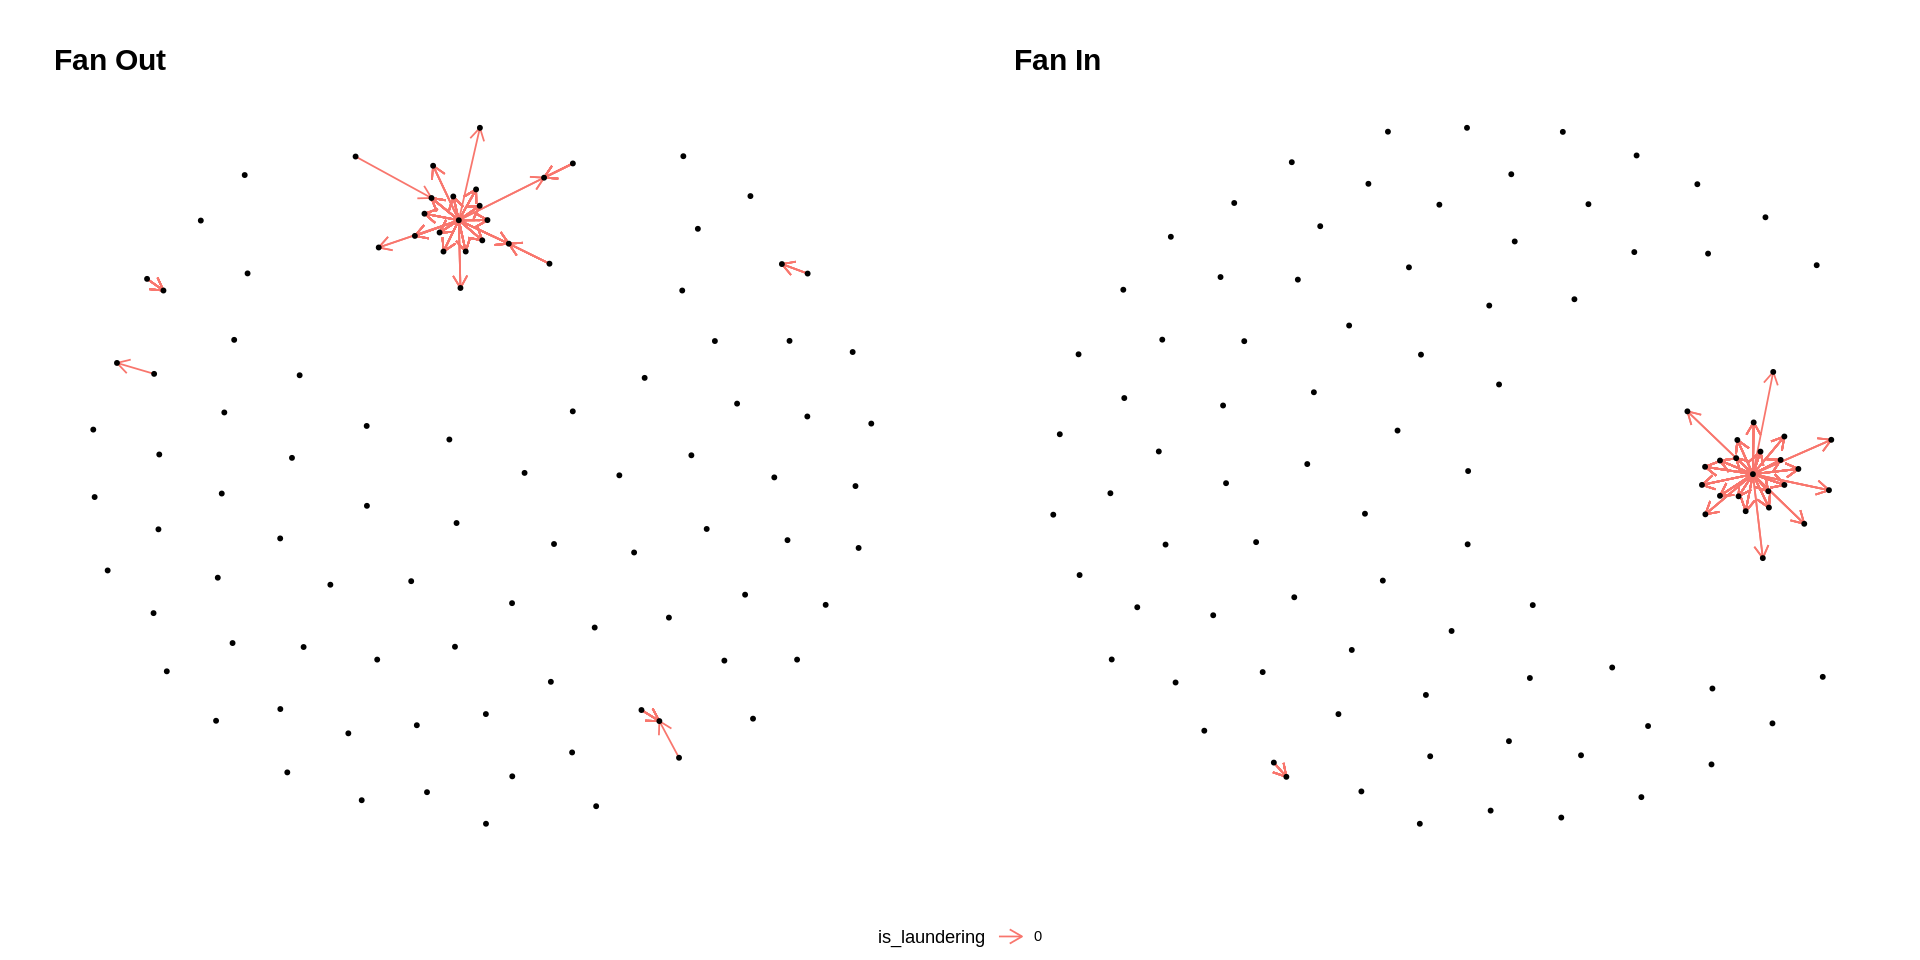

In [60]:
fig(16,8)

fan_out_transactions <- transactions_df |>
  filter(!payment_format %in% c("Wire", "Reinvestment")) |>
  select(from_account, to_account, is_laundering) |>
  rename(from = from_account, to = to_account) |>
  as_tbl_graph(directed = TRUE) |>
  activate(nodes) |>
  mutate(
    out_degree = centrality_degree(mode = "out"),
    in_degree = centrality_degree(mode = "in")
  ) |>
  filter((out_degree >= 5)) |>
  slice_head(n = 100)

fan_in_transactions <- transactions_df |>
  filter(!payment_format %in% c("Wire", "Reinvestment")) |>
  select(from_account, to_account, is_laundering) |>
  rename(from = from_account, to = to_account) |>
  as_tbl_graph(directed = TRUE) |>
  activate(nodes) |>
  mutate(
    out_degree = centrality_degree(mode = "out"),
    in_degree = centrality_degree(mode = "in")
  ) |>
  filter((in_degree >= 5)) |>
  slice_head(n = 100)

fan_out_chart <- ggraph(fan_out_transactions, layout = "fr") +
  geom_edge_link(aes(color = is_laundering), arrow = arrow(length = unit(3, 'mm'))) +
  geom_node_point(size = 1) +
  theme_graph(base_family = "sans") +
  labs(title = "Fan Out")

fan_in_chart <- ggraph(fan_in_transactions, layout = "fr") +
  geom_edge_link(aes(color = is_laundering), arrow = arrow(length = unit(3, 'mm'))) +
  geom_node_point(size = 1) +
  theme_graph(base_family = "sans") +
  labs(title = "Fan In")

ggarrange(fan_out_chart, fan_in_chart, common.legend = TRUE, legend = 'bottom')